In [18]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from joblib import dump, load

In [2]:
data = pd.read_csv('./dataset/Preprocessed_data.csv')

F:\AnacondaPackage\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ds_bert = torch.load('./dataset/featureDes')
ds_pca = torch.load('./dataset/pca_des')

In [4]:
data.head(3)

,description,origin,status,car_mileage,car_color,car_seats,gear,car_year,car_price,style,model,fuel,brand_name,region_name,url_image,website,month,year,num_null
0,🔹 HÀNG MỚI VỀ\n🔹 BMW 520i \n🔹 MODEL 2016\n🔹 Od...,Đức,Đã sử dụng,50000.0,Đen,4.0,Tự động,2015.0,1.170000e+09,Sedan,5 Series,Xăng,BMW,Hà Nội,https://cdn.chotot.com/namB6E0XkDPkf9h8KoahoRB...,chotot,11,2021,0
1,Bán nissan - Gran Livina nhập khẩu số tự động ...,Nhật Bản,Đã sử dụng,12000.0,Xám,3.0,Tự động,2009.0,2.342500e+08,Minivan (MPV),Grand livina,Xăng,Nissan,Hà Nội,https://cdn.chotot.com/50R_cYWFPAz0wHZqPAGaFr-...,chotot,11,2021,0
2,Auto88 về Mercedes C200 sx 2017 đky 2/2018 chạ...,Việt Nam,Đã sử dụng,30000.0,Xám,2.0,Tự động,2018.0,1.090000e+09,Sedan,C Class,Xăng,Mercedes Benz,Hà Nội,https://cdn.chotot.com/bhfeL3dPtccDnzlKzeAZ88X...,chotot,11,2021,0


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [6]:
class RandomForest:
    def __init__(self,data,ds_bert,ds_pca):
        self.cols_label = ['origin','status','car_color','gear','style','model','fuel','brand_name','website']
        self.cols_val = ['car_mileage','car_seats','car_year','month','year','num_null']
        self.ds_bert = np.array(ds_bert)
        self.ds_pca = np.array(ds_pca)
        self.car_price = data['car_price']
        self.y = np.log(self.car_price)
        self.le = preprocessing.LabelEncoder()
        self.data_label = data[self.cols_label].apply(self.le.fit_transform)
        self.data_val = pd.DataFrame(data[self.cols_val])
        self.data_val = self.precessUnknown(self.data_val)
        self.getFeature()
        self.split_data()

    def precessUnknown(self,data_val):
      for x in self.cols_val:
          noNull = data_val[data_val[x] != 'Unknown'][x].values
          median_value = np.median(noNull.astype(float))
          index = data_val[data_val[x] == 'Unknown'].index
          data_val.loc[index,x] = median_value
          data_val[x] = data_val[x].astype(float)
      return data_val

    def getFeature(self):
        self.X_normal = np.concatenate([self.data_val,self.data_label],axis = 1)
        self.X_bert = np.concatenate([self.data_val,self.data_label,self.ds_bert],axis = 1)
        self.X_pca = np.concatenate([self.data_val,self.data_label,self.ds_pca],axis = 1)
    def train(self,X_train,y_train):
        self.regr = RandomForestRegressor(max_depth=20, random_state=0)
        self.regr.fit(X_train, y_train)
        return self.regr
    def split(self,X):
        X_train, X_test, y_train, y_test = train_test_split(X, self.y, test_size=0.33, random_state=42)
        X_train = np.float64(X_train)
        y_train = np.float64(y_train)
        X_test = np.float64(X_test)
        y_test = np.float64(y_test)
        return X_train,y_train,X_test,y_test

    def split_data(self):
        self.X_train_normal,self.y_train_normal,self.X_test_normal,self.y_test_normal = self.split(self.X_normal)
        self.X_train_bert,self.y_train_bert,self.X_test_bert,self.y_test_bert = self.split(self.X_bert)
        self.X_train_pca,self.y_train_pca,self.X_test_pca,self.y_test_pca = self.split(self.X_pca)

In [7]:
ranForest = RandomForest(data,ds_bert,ds_pca)

# RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

{'n_estimators': [200, 300, 400, 500, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Normal

In [14]:
rf_random.fit(ranForest.X_train_normal,ranForest.y_train_normal)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600]},
                   random_state=42, verbose=2)

In [15]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=35, min_samples_leaf=2, n_estimators=300)

RandomForestRegressor normal

In [ ]:
rf_normal = RandomForestRegressor(max_depth=35, min_samples_leaf=2, n_estimators=300)
egr_normal = rf_normal.fit(ranForest.X_train_normal,ranForest.y_train_normal)
y_predict = rf_normal.predict(ranForest.X_test_normal)

In [27]:
print(mean_squared_error(ranForest.y_test_normal, y_predict))
from joblib import dump, load
dump(rf_normal, './dums/rf_normal.joblib') 

0.07008207814275078


['./dums/rf_normal.joblib']

RandomForestRegressor PCA

In [8]:
rf_pca = RandomForestRegressor(n_estimators=300)
rf_pca = rf_pca.fit(ranForest.X_train_pca,ranForest.y_train_pca)
y_predict_pca = rf_pca.predict(ranForest.X_test_pca)
print(mean_squared_error(ranForest.y_test_pca, y_predict_pca))
dump(rf_pca, './dums/rf_pca.joblib') 

0.08449675930568348


['./dums/rf_pca.joblib']

RandomForestRegressor Bert

In [ ]:
rf_bert = RandomForestRegressor(n_estimators=300)
rf_bert = rf_bert.fit(ranForest.X_train_bert,ranForest.y_train_bert) 

In [10]:
y_predict_bert = rf_bert.predict(ranForest.X_test_bert)
print(mean_squared_error(ranForest.y_test_bert, y_predict_bert))
from joblib import dump, load
dump(rf_bert, './dums/rf_bert.joblib')

0.08417705977943694


['./dums/rf_bert.joblib']

In [13]:
def saveDataTrain(X_train,y_train,X_test,y_test,type):
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    X_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test)
    torch.save(X_train,f'./datatrain/X_train_{type}')
    torch.save(y_train,f'./datatrain/y_train_{type}')
    torch.save(X_test,f'./datatrain/X_test_{type}')
    torch.save(y_test,f'./datatrain/y_test_{type}')

In [15]:
saveDataTrain(ranForest.X_train_bert,ranForest.y_train_bert,ranForest.X_test_bert,ranForest.y_test_bert,'bert')
saveDataTrain(ranForest.X_train_pca,ranForest.y_train_pca,ranForest.X_test_pca,ranForest.y_test_pca,'pca')
saveDataTrain(ranForest.X_train_normal,ranForest.y_train_normal,ranForest.X_test_normal,ranForest.y_test_normal,'normal')

R-squared

In [17]:
#bert
r2_score(ranForest.y_test_bert, y_predict_bert)

0.9043033453102408

In [20]:
#pca
rf_pca = load('./dums/rf_pca.joblib')
y_predict_pca = rf_pca.predict(ranForest.X_test_pca)
r2_score(ranForest.y_test_pca, y_predict_pca)

0.9039398950394918

In [22]:
#normal
rf_normal = load('./dums/rf_normal.joblib')
y_predict_normal = rf_normal.predict(ranForest.X_test_normal)
r2_score(ranForest.y_test_normal, y_predict_normal)

0.920327219202709

# Distribution of car price

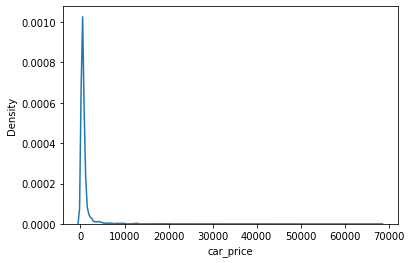

In [28]:
sns.kdeplot(data.car_price/1e6)

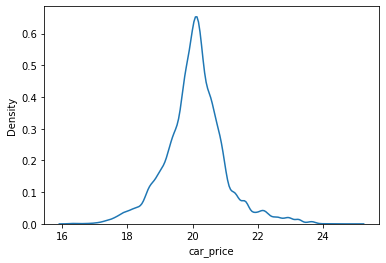

In [27]:
sns.kdeplot(y)